In [1]:
print(__doc__)

# Author: Zehui Li
# Time 2018/11/01

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm import tqdm
import math

Automatically created module for IPython interactive environment


## Generate the data and Do some experiment

In [2]:
#K means Clustering 
def doKmeans(X, nclust=3):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    #cent = model.cluster_centers_
    return clust_labels

In [3]:
n_samples = 100

In [4]:
# Generate 3 blobs with 2 classes where the second blob 
# Cluster_std is the standard deviation, random_state is used for reproduce the experiment 
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=3,
                  centers=centers, shuffle=True, random_state=42)

In [5]:
clust_labels = doKmeans(X, 3)

kmeans = pd.DataFrame(clust_labels)

In [6]:
X.shape

(100, 2)

### This is the clustering results of the k-mean

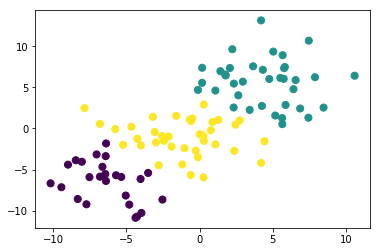

In [7]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X[:,0],X[:,1],c=kmeans[0],s=50)

### This is what the original data look like 

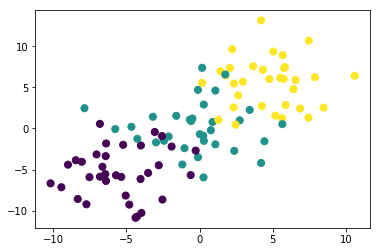

In [8]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X[:,0],X[:,1],c=y,s=50)

#### Create a sample Matrix from 2-d data

In [9]:
from scipy.spatial.distance import euclidean, pdist, squareform

data = X
def similarity_func(u, v):
    return euclidean(u,v)

DF_var = pd.DataFrame.from_dict(data)
dists = pdist(DF_var, similarity_func)
dist_matric = squareform(dists)

#### K medoid

In [10]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer;
from pyclustering.utils import timedcall;

In [11]:
kmedoids_instance = kmedoids(dist_matric, [1,2,3], 0.25,data_type='distance_matrix');
(ticks, result) = timedcall(kmedoids_instance.process);
clusters = kmedoids_instance.get_clusters();
medoids = kmedoids_instance.get_medoids();

### Visualize the result of k - mediod

In [12]:
def convert_pycluster_to_sklearn(pycluster_input):
    result = np.zeros(len([j for i in pycluster_input for j in i]))
    for i,myInd in np.ndenumerate(pycluster_input):
        result[myInd] = i
    return result

### Reuslt of k-medoid

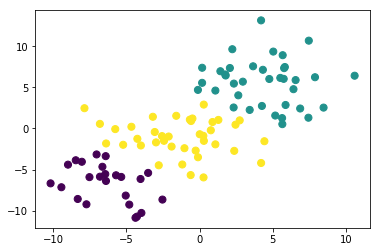

In [13]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X[:,0],X[:,1],c=convert_pycluster_to_sklearn(clusters),s=50)

## First define the function to perturb the data

In [14]:
#It is very diffcult to perturb the data with specific coordinates subjust to two constraints

In [15]:
def perturb(data,partition_of_data,ramdomSeed):
    #leave it to later
    pass

## Define the perturbation function for data only given the similarity matrix

https://stackoverflow.com/questions/47321133/sklearn-hierarchical-agglomerative-clustering-using-similarity-matrix
Showing the hierachical clustering using the similartiy matrix

In [16]:
def perturb_distance_matrix_random(in_matrix,partition,random_seed):
    matrix = np.matrix.copy(in_matrix)
    #In one cluster: Randomly select the x pair of points
    temp_upper_bound = factorial(len(partition))/(factorial(len(partition)-2)*2)
    loop_time = random.randint(1,temp_upper_bound+1)
    array = np.arange(len(partition))
    #Randomly reduce the distance between each pair
    for j in range(1,loop_time+1):
        pair = np.random.choice(array,2,False)
        matrix[pair[0],pair[1]]=  matrix[pair[1],pair[0]]= random.uniform(0, 1)*random.randint(1,10)*matrix[pair[1],pair[0]]
    return matrix

### Perburbation function definition

In [17]:
import random
from math import factorial
# take the similarity matrix, partition result
# and ramdom_seed (which is used to reproduce the experiment)
def perturb_distance_matrix(in_matrix,partition,random_seed):
    matrix = np.matrix.copy(in_matrix)
    #take the index of first,second ... cluster
    partition_list = list()
    for i in np.unique(partition):
        index_i = np.where(partition==i)
        if len(index_i[0])!=1:
            #In one cluster: Randomly select the x pair of points
            temp_upper_bound = factorial(len(index_i[0]))/(factorial(len(index_i[0])-2)*2)
            loop_time = random.randint(1,temp_upper_bound+1)
            #Randomly reduce the distance between each pair
            for j in range(1,loop_time+1):
                pair = np.random.choice(index_i[0],2,False)
                matrix[pair[0],pair[1]]=  matrix[pair[1],pair[0]]= random.uniform(0, 1)*matrix[pair[1],pair[0]]
            #store the partition into the list
        partition_list.append(index_i[0])
    #Ramdonmly select x' pair of clusters
    temp_upper_bound = factorial(len(partition_list))/(factorial(len(partition_list)-2)*2)
    loop_time = random.randint(1,temp_upper_bound+1)
    #increate the distance between clusters with a random ratio
    for i in range(1,loop_time+1):
        cluster_pair = random.sample(partition_list,2)
        #create a ramdom generated matrix - then do elementwise multiplication
        increase_coefficient = np.multiply((np.random.rand(cluster_pair[0].shape[0],cluster_pair[1].shape[0])+1),(np.random.randint(4,size=(cluster_pair[0].shape[0],cluster_pair[1].shape[0]))+1))
        temp_multiplier = np.multiply(matrix[np.ix_(cluster_pair[0],cluster_pair[1])],increase_coefficient)
        matrix[np.ix_(cluster_pair[0],cluster_pair[1])]= temp_multiplier
       # the points are symmetric to each other, so do the corresponding changes
        matrix[np.ix_(cluster_pair[1],cluster_pair[0])] = np.matrix.transpose(temp_multiplier)

    return matrix

In [18]:
dist_matric2=perturb_distance_matrix(dist_matric,convert_pycluster_to_sklearn(clusters),1)

### Define the Metric1

#### Hausdorff distance 

In [19]:
#calculate the Hausdorff distance between two metrix space give the distance matrix point of distance matrix
def Hausdorff(distMatrix,set1_index,set2_index):
    inf_set1 = [np.ndarray.min(distMatrix[set2_index,i]) for i in set1_index]
    inf_set2 = [np.ndarray.min(distMatrix[set1_index,i]) for i in set2_index]
    a = max(inf_set1)
    b = max(inf_set2)
    return max(a,b)

In [20]:
dist_matric[3,2]

5.519632533007673

In [21]:
#Hausdorff(dist_matric,np.where(partition==1)[0],np.where(partition==2)[0])

### Calculate the Metric1

In [22]:
import itertools
#define the helper function to calculate the metric
#take two lists as the input
def subMetric1(list1,list2):
    #we have D= d1+d2 + di
    #D' = d1' + d2' + di'
    #sum 1/c * (abs(di/D - di'/D'))
    D1 = sum(list1)
    D2 = sum(list2)
    temp_sum = 0
    for i,j in zip(list1,list2):
        temp_sum += abs(i/D1-j/D2)
    return temp_sum/len(list1)

#calculate the Metric1
def Metric1(distMatrix1,distMatrix2,partition):
    #get the permutation of the two clusters in this partition    
    list_clusters = [np.where(partition==i)[0] for i in np.unique(partition)]
    list_combination=list(itertools.combinations(list_clusters,2))
    
    #Store the two distance in two list
    #for each pair, calculate the distance between the pair, stored as d1, d2
    list_dist1, list_dist2 = [],[]
    for pair in list_combination:
        dist_i = Hausdorff(distMatrix1,pair[0],pair[1])
        dist2_i = Hausdorff(distMatrix2,pair[0],pair[1])
        list_dist1.append(dist_i)
        list_dist2.append(dist2_i)
    return subMetric1(list_dist1,list_dist2)

In [23]:
#Test the function
#Metric1(dist_matric,dist_matric2,partition)

### Calculate the Metric2

In [24]:
#calculate the second Metric2
def Metric2(distMatrix1,distMatrix2,partition):
    list_clusters = [np.where(partition==i)[0] for i in np.unique(partition)]
    temp_sum = 0
    for i in list_clusters:
        # get the combination of the points within this clusters
        # change to sampling points to speed up the program later
        list_combination=list(itertools.combinations(i,2))
        list_dist1, list_dist2 = [],[]
        for pair in list_combination:
            dist_i = distMatrix1[pair[0],pair[1]]
            dist2_i = distMatrix2[pair[0],pair[1]]
            list_dist1.append(dist_i)
            list_dist2.append(dist2_i)
        temp_sum+=subMetric1(list_dist1,list_dist2)
    return temp_sum/len(list_clusters)

In [25]:
#Metric2(dist_matric,dist_matric2,partition)

### Calculate the rand index

In [26]:
from scipy.misc import comb
from itertools import combinations
import numpy as np

def check_clusterings(labels_true, labels_pred):
    """Check that the two clusterings matching 1D integer arrays."""
    labels_true = np.asarray(labels_true)
    labels_pred = np.asarray(labels_pred)    
    # input checks
    if labels_true.ndim != 1:
        raise ValueError(
            "labels_true must be 1D: shape is %r" % (labels_true.shape,))
    if labels_pred.ndim != 1:
        raise ValueError(
            "labels_pred must be 1D: shape is %r" % (labels_pred.shape,))
    if labels_true.shape != labels_pred.shape:
        raise ValueError(
            "labels_true and labels_pred must have same size, got %d and %d"
            % (labels_true.shape[0], labels_pred.shape[0]))
    return labels_true, labels_pred

def rand_score (labels_true, labels_pred):
    """given the true and predicted labels, it will return the Rand Index."""
    check_clusterings(labels_true, labels_pred)
    my_pair = list(combinations(range(len(labels_true)), 2)) #create list of all combinations with the length of labels.
    def is_equal(x):
        return (x[0]==x[1])
    my_a = 0
    my_b = 0
    for i in range(len(my_pair)):
            if(is_equal((labels_true[my_pair[i][0]],labels_true[my_pair[i][1]])) == is_equal((labels_pred[my_pair[i][0]],labels_pred[my_pair[i][1]])) 
               and is_equal((labels_pred[my_pair[i][0]],labels_pred[my_pair[i][1]])) == True):
                my_a += 1
            if(is_equal((labels_true[my_pair[i][0]],labels_true[my_pair[i][1]])) == is_equal((labels_pred[my_pair[i][0]],labels_pred[my_pair[i][1]])) 
               and is_equal((labels_pred[my_pair[i][0]],labels_pred[my_pair[i][1]])) == False):
                my_b += 1
    my_denom = comb(len(labels_true),2)
    ri = (my_a + my_b) / my_denom
    return ri

In [27]:
def kmediod_tester(dist_matrix):
    kmedoids_instance = kmedoids(dist_matrix, [1,2,3], 0.25,data_type='distance_matrix');
    (ticks, result) = timedcall(kmedoids_instance.process);
    clusters = kmedoids_instance.get_clusters();
    return convert_pycluster_to_sklearn(clusters)

In [28]:
iterate_time = 1000
d1 = np.zeros(iterate_time)
d2 = np.zeros(iterate_time)
d3 = np.zeros(iterate_time)
for i in tqdm(range(1,iterate_time)):
    dist_matrix=dist_matric
    partition = kmediod_tester(dist_matrix)
    dist_matric2 = perturb_distance_matrix(dist_matric,partition,1)
    d1[i]=Metric1(dist_matric,dist_matric2,partition)
    d2[i]=Metric2(dist_matric,dist_matric2,partition)
    partition2 = kmediod_tester(dist_matric2)
    d3[i]=adjusted_rand_score(partition,partition2)

100%|██████████| 999/999 [00:48<00:00, 22.51it/s]


In [29]:
np.where(d3==0)

(array([0], dtype=int64),)

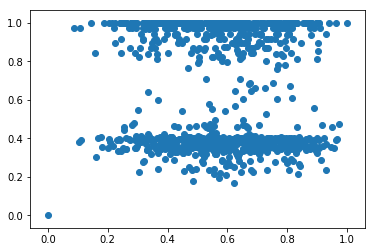

In [30]:
import matplotlib.pyplot as plt
#ax = plt.axes(projection='3d')
#ax.scatter3D(d1,d2,d3);

 #Data for a three-dimensional line

temp = d1/np.max(d1)
temp2 = d2/np.max(d2)
plt.scatter(temp2,d3)
plt.show()


In [31]:
from scipy.stats.stats import pearsonr     
pearsonr(d2,d3)

(-0.02212125160489703, 0.4847107951519065)

In [32]:
np.corrcoef(temp2, d3)

array([[ 1.        , -0.02212125],
       [-0.02212125,  1.        ]])

(array([  1.,   3.,  42., 390., 111.,   9.,  12.,   8.,  68., 356.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

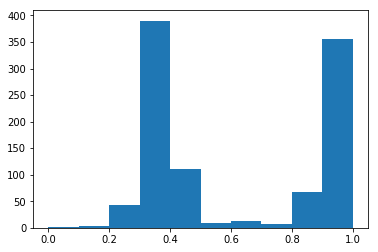

In [33]:
plt.hist(d3)

(array([ 98., 333., 135., 136., 143.,  58.,  42.,  32.,  15.,   8.]),
 array([0.        , 0.04624628, 0.09249257, 0.13873885, 0.18498514,
        0.23123142, 0.27747771, 0.32372399, 0.36997028, 0.41621656,
        0.46246284]),
 <a list of 10 Patch objects>)

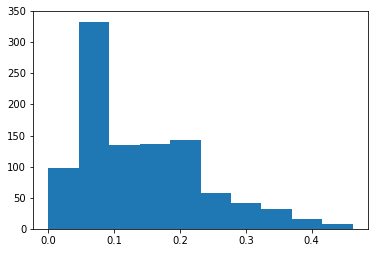

In [34]:
plt.hist(d1)

(array([  1.,   3.,  42., 390., 111.,   9.,  12.,   8.,  68., 356.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

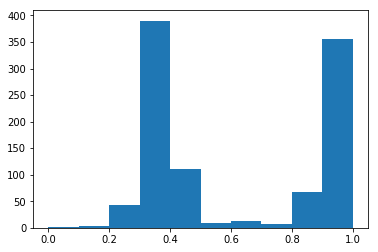

In [35]:
plt.hist(d3)

### Single linkage

In [36]:
from sklearn.cluster import AgglomerativeClustering
def single_linkage_tester(dist_matrix):
    model = AgglomerativeClustering(affinity='precomputed', n_clusters=10, linkage='single').fit(dist_matrix)
    return model.labels_

In [37]:
model = AgglomerativeClustering(affinity='precomputed', n_clusters=20, linkage='single').fit(my_dist_matrix)
model.labels_

NameError: name 'my_dist_matrix' is not defined

In [ ]:
iterate_time = 1000
d1 = np.zeros(iterate_time)
d2 = np.zeros(iterate_time)
d3 = np.zeros(iterate_time)
for i in tqdm(range(0,iterate_time)):
    dist_matrix=dist_matric
    partition = single_linkage_tester(dist_matrix)
    dist_matric2 = perturb_distance_matrix(dist_matric,partition,1)
    d1[i]=Metric1(dist_matric,dist_matric2,partition)
    #2[i]=Metric2(dist_matric,dist_matric2,partition)
    partition2 =single_linkage_tester(dist_matric2)
    d3[i]=adjusted_rand_score(partition,partition2)

In [ ]:
d3_new.size

In [ ]:
plt.hist(d3)

In [ ]:
d1_new=d1[np.where(d3<0.39)]
d3_new=d3[np.where(d3<0.39)]

In [ ]:
plt.scatter(d1_new,d3_new)
plt.show()
d1_new.shape

In [ ]:
d1_new=d1[np.where(d3==1)]
d3_new=d3[np.where(d3==1)]
d1_new = d1_new[np.where(d1_new<0.3)]
d3_new = d3_new[np.where(d1_new<0.3)]

In [ ]:
plt.scatter(d1_new,d3_new)
plt.show()
d1_new.shape

In [ ]:
np.corrcoef(d1, d3)

In [ ]:
b=convert_pycluster_to_sklearn(clusters2)

In [ ]:

adjusted_rand_score(a,b)

In [ ]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X[:,0],X[:,1],c=a,s=50)

In [ ]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X[:,0],X[:,1],c=b,s=50)

### Using learning algorithm to find the relation between the changes of distance matrix and rand index

### Gnerate the dataset

In [ ]:
1
iterate_time = 10000
matrix_list = []
rand_score_array = np.zeros(iterate_time)
for i in tqdm(range(0,iterate_time)):
    dist_matrix=dist_matric
    partition = kmediod_tester(dist_matrix)
    dist_matric2 = perturb_distance_matrix(dist_matric,partition,1)
    matrix_list.append(dist_matric2)
    partition2 = kmediod_tester(dist_matric2)
    rand_score_array[i]=adjusted_rand_score(partition,partition2)

In [38]:
from sklearn import preprocessing
def upperTri(ele):   
    #this function produce a matrix with upper triangle equals 1 and other element equals -1
    dimention = int(math.sqrt(ele.shape[0]))
    result = np.ones((dimention, dimention))*(-1)
    result = np.matrix(result).A1
    for i in range(1,dimention):
        for j in range(i,dimention):
            my_index = (i-1)*dimention + j
            result[my_index] = 1
    return result
def select_attributes(input_features):
    help_matrix = upperTri(input_features[0])
    temp_features = [(help_matrix*ele) for ele in input_features]
    return [ele[ele>=0] for ele in temp_features]


def generate_data_help(num_iter=3000,label_threshold=0.8):
    re_matrix_list = []
    rand_score_array = np.zeros(num_iter)
    for i in tqdm(range(0,num_iter)):
        dist_matrix=dist_matric
        partition = kmediod_tester(dist_matrix)
        dist_matric2 = perturb_distance_matrix(dist_matric,partition,1)
        re_matrix_list.append(dist_matric2)
        partition2 = kmediod_tester(dist_matric2)
        rand_score_array[i]=adjusted_rand_score(partition,partition2)
    labels = (rand_score_array>=label_threshold).astype(int)
    features = [np.matrix(ele).A1 for ele in re_matrix_list]
    reduced_features = select_attributes(features)
    return reduced_features,labels

In [39]:
def generate_data(num_iter=3000,label_threshold=0.8):
    reduced_features,labels = generate_data_help(num_iter,label_threshold)
    standardized_reduced_features = preprocessing.scale(reduced_features)
    return standardized_reduced_features,labels

In [44]:
features,labels = generate_data(10000,1)

100%|██████████| 10000/10000 [06:33<00:00, 25.42it/s]


In [45]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(features,labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [46]:
X_test, y_test = generate_data(label_threshold=1)

100%|██████████| 3000/3000 [01:56<00:00, 26.39it/s]


In [47]:
clf.score(X_test, y_test)

0.7886666666666666

(array([7747.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2253.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

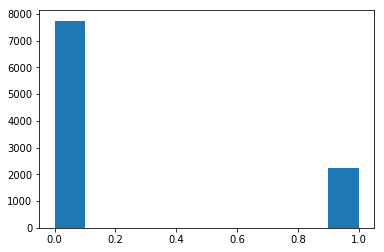

In [49]:
plt.hist(labels)

### Decision Tree

In [ ]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(features,labels)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [51]:
from sklearn.ensemble import RandomForestClassifier

clf_rf= RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf_rf.fit(features,labels)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### Measure the performance

In [57]:
from sklearn.metrics import classification_report
y_true = y_test
y_pred = clf_rf.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))


C:\Users\ljh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

     class 0       0.76      1.00      0.86      2279
     class 1       0.00      0.00      0.00       721

   micro avg       0.76      0.76      0.76      3000
   macro avg       0.38      0.50      0.43      3000
weighted avg       0.58      0.76      0.66      3000



In [ ]:
y_pred = clf.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(clf_tree, open(filename, 'wb'))


In [ ]:
import pickle
# load the model from disk
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))

In [66]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(clf_rf.estimators_[1],rounded = True,proportion = False,precision = 2,filled = True) 
graph = graphviz.Source(dot_data) 

In [67]:
def calcIndex(given_index,dimention=100):
    my_index = 0
    for i in range(0,dimention):
        for j in range(i,dimention):
            if (given_index == my_index):
                return(i,j)
            my_index+=1

In [68]:
graph.save("Source.gv")

'Source.gv'

In [ ]:
from graphviz import Source
temp = ""
s = Source(temp, filename="Source.gv", format="png")

In [83]:
list_coodinates = []
list_estimator = clf_rf.estimators_
for loaded_model in list_estimator:
    tree_ =loaded_model.tree_
    list_features = [i for i in tree_.feature]
    for ele in list_features:
        if ele != -2:
            temp = calcIndex(ele)
            if(not(temp in list_coodinates)):
                list_coodinates.append(temp)

In [72]:
tree_ =loaded_model.tree_
list_features = [i for i in tree_.feature]
list_coodinates = []
for ele in list_features:
    if ele != -2:
        temp = calcIndex(ele)
        if(not(temp in list_coodinates)):
            list_coodinates.append(temp)
print(list_coodinates)

[(46, 98), (2, 83), (14, 78)]


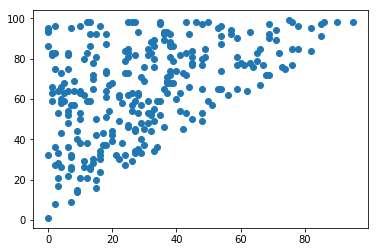

In [84]:
import matplotlib.pyplot as plt
plt.scatter(*zip(*list_coodinates))
plt.savefig("tree2.png")

In [82]:
len(list_coodinates)

3

### Dimention reduction using PCA

### We first treat it as a classificaiton problem

In [ ]:
plt.hist(rand_score_array)

In [ ]:
# create a label for our training data
# set the data point to 1 if the rand index is 1, set it to zero otherwise
labels = (rand_score_array>=0.8).astype(int)
df = pd.DataFrame(labels)

In [ ]:
#coeff_matrix

In [ ]:
#convert the matrix to features vector
#TODO truncate the extra element
features = [np.matrix(ele).A1 for ele in matrix_list]
#features.append(np.matrix(dist_matric).A1)

In [ ]:
#take the upper triangle of the distance matrix

def upperTri(ele):   
    #this function produce a matrix with upper triangle equals 1 and other element equals -1
    dimention = int(math.sqrt(ele.shape[0]))
    result = np.ones((dimention, dimention))*(-1)
    result = np.matrix(result).A1
    for i in range(1,dimention):
        for j in range(i,dimention):
            my_index = (i-1)*dimention + j
            result[my_index] = 1
    return result

In [ ]:
def select_attributes(input_features):
    help_matrix = upperTri(input_features[0])
    temp_features = [(help_matrix*ele) for ele in input_features]
    return [ele[ele>=0] for ele in temp_features]

In [ ]:
reduced_features = select_attributes(features)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
# Fit on training set only.
scaler.fit(reduced_features)

In [ ]:
# Apply transform to both the training set and the test set.
features_transformed = scaler.transform(reduced_features)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
principalComponents = pca.fit_transform(features_transformed)

In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
finalDf = pd.concat([principalDf, df], axis = 1)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Try to come up with another distance

In [ ]:
substracted_value = [np.sum((i-reduced_features[len(reduced_features)-1])**2) for i in reduced_features]

In [ ]:
x = np.asarray(substracted_value[:-1])
y = np.asarray(labels)

In [ ]:
plt.scatter(x,y)
plt.show()

#### Data exploration

In [ ]:
np.asarray(reduced_features).shape

In [ ]:
temp=np.asarray(reduced_features[:-1])
clust_labels = doKmeans(temp, 2)
kmeans = pd.DataFrame(clust_labels)

In [ ]:
temp.shape

In [ ]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(temp[:,386],temp[:,400],c=labels,s=50)

In [ ]:
#Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(temp[:,386],temp[:,400],c=kmeans[0],s=50)

### Using SVM to classify the data

In [ ]:
labels = (rand_score_array>=0.8).astype(int)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(reduced_features)
features_transformed = scaler.transform(reduced_features)

In [ ]:
X = features_transformed
y = labels

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1000).fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X, y)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
clf

Test

In [ ]:
iterate_time = 3000
matrix_list = []
rand_score_array = np.zeros(iterate_time)
for i in tqdm(range(0,iterate_time)):
    dist_matrix=dist_matric
    partition = kmediod_tester(dist_matrix)
    dist_matric2 = perturb_distance_matrix(dist_matric,partition,1)
    matrix_list.append(dist_matric2)
    partition2 = kmediod_tester(dist_matric2)
    rand_score_array[i]=adjusted_rand_score(partition,partition2)

In [ ]:
features = [np.matrix(ele).A1 for ele in matrix_list]
reduced_features = select_attributes(features)
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(reduced_features)
new_features_transformed = scaler.transform(reduced_features)
new_labels = (rand_score_array>=0.8).astype(int)


In [ ]:
clf.score(new_features_transformed, new_labels)

 #### Visulize the svm model

In [ ]:
plt.scatter(X_train[:, 20], X_train[:, 30], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
print(xy.shape)
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [ ]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [ ]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:
X0, X1 = X_train, y_train
xx, yy = make_meshgrid(X0, X1)


plot_contours(ax, clf, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Sepal length')
ax.set_ylabel('Sepal width')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)

plt.show()